In [ ]:
import pandas as pd

credit = pd.read_csv('data/german_credit_final.csv')

In [13]:
from sklearn.model_selection import train_test_split

X = credit.drop(columns=['risk'])
y = credit['risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [10]:
y.value_counts(normalize=True)

risk
1    0.7
0    0.3
Name: proportion, dtype: float64

In [14]:
y_train.value_counts(normalize=True)

risk
1    0.7
0    0.3
Name: proportion, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

risk
1    0.7
0    0.3
Name: proportion, dtype: float64

# Drzewo decyzyjne

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

clf_tree = DecisionTreeClassifier(random_state=42, max_depth=4, )
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [ ]:
! pip install matplotlib

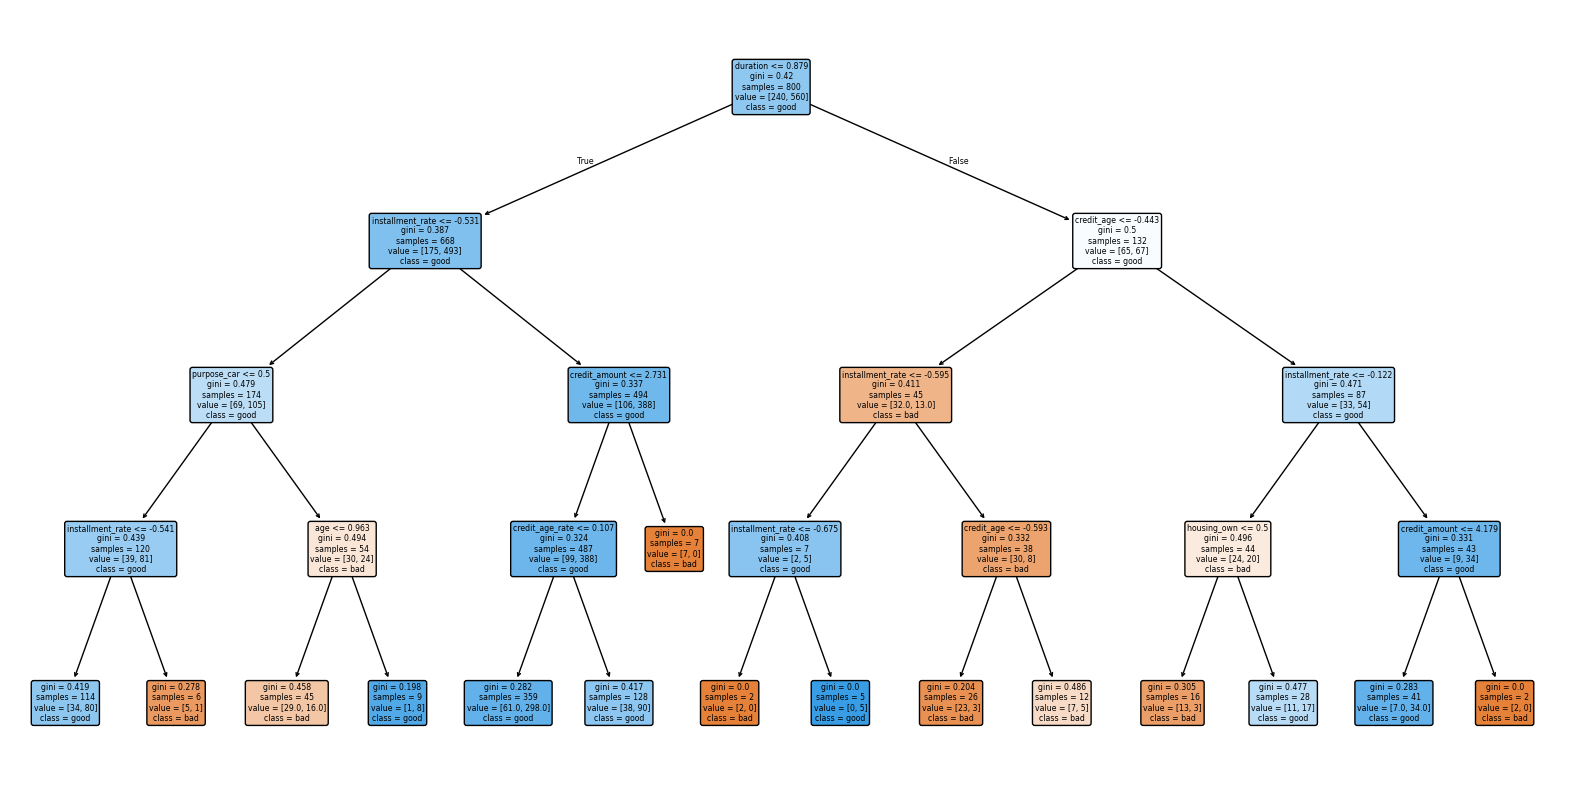

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(clf_tree, filled=True, feature_names=X.columns, class_names=['bad', 'good'], rounded=True)
plt.show()

## Ocena jakości modelu

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score

y_pred_train_tree = clf_tree.predict(X_train)
confusion_matrix(y_train, y_pred_train_tree)

array([[ 88, 152],
       [ 28, 532]])

In [31]:
print(classification_report(y_train, y_pred_train_tree))

              precision    recall  f1-score   support

           0       0.76      0.37      0.49       240
           1       0.78      0.95      0.86       560

    accuracy                           0.78       800
   macro avg       0.77      0.66      0.67       800
weighted avg       0.77      0.78      0.75       800



In [40]:
def evaluate_model(y_true, y_pred):

    print("Confusion Matrix:") 
    print(confusion_matrix(y_true, y_pred))

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    specificity = tn / (tn + fp)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Balanced Accuracy: {balanced_accuracy:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Specificity: {specificity:.4f}')

In [42]:
evaluate_model(y_train, y_pred_train_tree)

Confusion Matrix:
[[ 88 152]
 [ 28 532]]
Accuracy: 0.7750
Balanced Accuracy: 0.6583
Recall: 0.9500
Precision: 0.7778
F1 Score: 0.8553
Specificity: 0.3667
